<a href="https://colab.research.google.com/github/jtwang1027/cancer_omics/blob/master/cell_line_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


exploring transcriptomic, copy number variant, and proteomic data

In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns

PCA to compare baseline starting points of different cell lines


In [0]:
def pca_plot(filename, catcol=None, dim_method='PCA' ,title='PCA'):
  ''' reads in csv file, standardizes data, and generates PCA plot ;
  catcol is the column to color the scatter plot by; title= plot title;
  dim_method: pca or tsne'''
  
  
  
  #reading in data and scaling
  df=pd.read_csv(filename)
  
  #for coloring plot
  if catcol is not None: #color column is supplied
    categories = np.unique(df[catcol])
    ncolors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, ncolors))  
    color = df[catcol].apply(lambda x: colordict[x])
  else:
    color= np.zeros(df.shape[0])
  
  
  df= df.select_dtypes(include='float64')
  df.dropna(axis=1, inplace=True)
  df_scaled = StandardScaler().fit_transform(df) # normalizing the features
  
  
  
  if dim_method=='PCA' or dim_method=='pca': #pca
    dr = PCA(n_components=2)
    print('using PCA')
  else: #t-sne
    print('using tsne')
    dr = TSNE(n_components=2)
    
    
  principalComponents = dr.fit_transform(df_scaled)

  pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
  
  ax=plt.figure()
  plt.figure(figsize=(4,4))
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=14)
  plt.xlabel('Component 1',fontsize=20)
  plt.ylabel('Component 2',fontsize=20)
  plt.title(title,fontsize=20)
  plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], c=color)
#   plt.legend(categories)
  return (None)

using PCA


<Figure size 432x288 with 0 Axes>

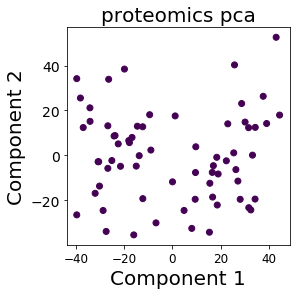

In [0]:
pca_plot('/content/drive/My Drive/proteomics_consolidated.csv',title='proteomics pca')

using tsne


<Figure size 432x288 with 0 Axes>

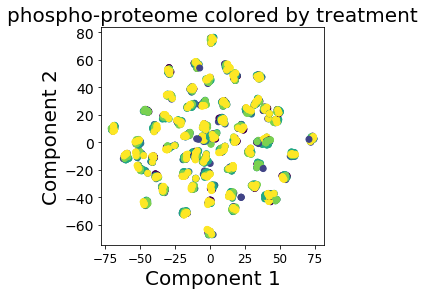

In [0]:
pca_plot('/content/drive/My Drive/median_phospho_data.csv', catcol='treatment', dim_method='tsne', title='phospho-proteome colored by treatment')

using tsne


<Figure size 432x288 with 0 Axes>

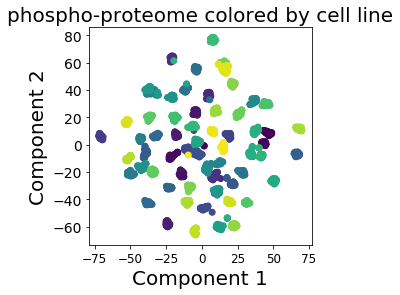

In [0]:
pca_plot('/content/drive/My Drive/median_phospho_data.csv', catcol='cell_line', dim_method='tsne', title='phospho-proteome colored by cell line')

Cell lines cluster together based on phosphorylation data.

using PCA


<Figure size 432x288 with 0 Axes>

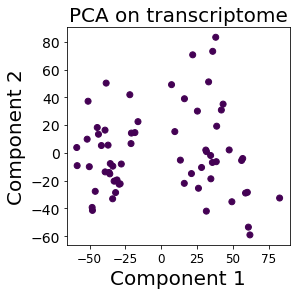

In [0]:
pca_plot('/content/drive/My Drive/rnaseqexononly_marcotte.csv',dim_method='pca',title='PCA on transcriptome')



There appear to be 2 clusters of cell lines based on the transcriptome.

In [0]:
tr=pd.read_csv('/content/drive/My Drive/rnaseqexononly_marcotte.csv')

In [0]:
cell_lines= tr['X']
tr= tr.select_dtypes(include='float64')
tr.dropna(axis=1, inplace=True)
tr_sc= StandardScaler().fit_transform(tr)
# tr_pca=PCA(n_components=5).fit_transform(tr_sc)

In [0]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(tr_sc)
kmeans.labels_

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
      dtype=int32)

Text(0.5, 1.0, 'Transcriptomics PCA with clustering')

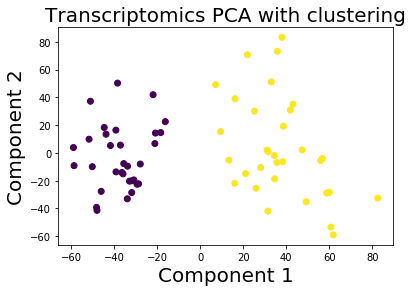

In [0]:
plt.scatter( tr_pca[:,0],tr_pca[:,1], c= kmeans.labels_)
plt.xlabel('Component 1',fontsize=20)
plt.ylabel('Component 2',fontsize=20)
plt.title("Transcriptomics PCA with clustering",fontsize=20)

how do these clusters localize in other omics data types?

In [0]:
#which cell lines belong to each cluster?
lclass=dict(zip(cell_lines, kmeans.labels_))

In [0]:
prot=pd.read_csv('/content/drive/My Drive/proteomics_consolidated.csv')

In [0]:
prot.rename(columns={'Unnamed: 0':'cell_line'}, inplace=True)

In [0]:
prot['line_class']=prot['cell_line'].map(lclass)

keep only cell lines that are in dict (and were clustered from the transcriptomic data)

In [0]:
keep=prot['cell_line'].isin(list(lclass.keys()))
prot=prot[keep]
# prot['cell_line'] in list(lclass.keys())

In [0]:
prot.to_csv('/content/drive/My Drive/proteomics_consol_cell-classes.csv')

using PCA


<Figure size 432x288 with 0 Axes>

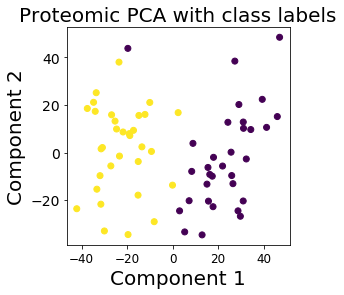

In [0]:
pca_plot('/content/drive/My Drive/proteomics_consol_cell-classes.csv', catcol='line_class',title='Proteomic PCA with class labels')

Classes assigned based on transcriptomic data, also show distinctions in proteomic data

Looking for common (phosphorylation) responses to drug treatments in the cell lines. Let's look at the ***'184a1***'

In [0]:
cell_line='184a1'
pprot= pd.read_csv('/content/drive/My Drive/complete_cell_lines/' + cell_line + '.csv')

The table contains expression data for several proteins based on treatment molecule & time after treatment. ('full' treatment means no treatment in this case)

In [0]:
pprot=pprot.sample(50000)

In [0]:
pprot.describe()

,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,16.026130,4393.940920,2676.762200,1.283690,2.596782,2.037735,3.149593,5.238983,2.492403,1.967588,2.450105,2.520497,3.506740,2.518650,0.786263,3.041703,1.880252,1.994916,3.359597,4.530423,1.881028,1.454659,1.796334,2.612616,2.408116,3.827592,2.336262,2.255091,1.544648,2.992794,2.554435,2.077349,4.650803,4.886411,2.159670,2.283125,1.851097,2.340695,2.544257,2.180224
std,17.837509,2909.519429,17.173875,0.687782,0.901954,0.969078,0.916103,1.257729,1.032593,1.074091,0.906839,0.849652,0.630845,0.831917,0.544975,1.038766,0.722328,0.887056,1.249909,0.775173,0.824911,0.704990,0.841034,0.852704,0.943839,1.177755,0.646929,0.921468,0.652697,1.046166,0.912529,0.866077,1.348848,1.401684,0.893121,0.819183,0.769981,0.754590,1.127427,0.734590
min,0.000000,1.000000,2648.000000,0.224784,0.898342,1.204890,0.565534,4.250200,1.590850,0.993163,0.550685,0.895138,0.066427,0.543688,0.342839,0.442259,0.462350,1.101180,1.035910,0.881374,0.688867,0.364099,0.499066,-0.132428,0.500146,1.005680,-0.619959,0.448364,0.798554,1.056820,0.516309,0.986227,2.207940,2.396320,0.331558,0.551474,0.554053,-0.341181,0.652426,-0.577393
25%,5.500000,2005.000000,2661.000000,0.709408,1.987968,1.204890,2.605744,4.250200,1.590850,0.993163,1.861065,1.951626,3.121973,2.025552,0.342840,2.345414,1.403685,1.101180,2.494177,4.109612,1.169206,0.891717,1.137164,2.096553,1.778533,3.040847,1.930632,1.639089,0.798869,2.293505,1.978508,1.256722,3.648955,3.883422,1.577483,1.771157,1.296530,1.880645,1.718470,1.759115
50%,9.000000,4043.000000,2675.000000,1.349007,2.701183,1.838070,3.279987,5.056875,2.155355,1.650851,2.479979,2.660862,3.562549,2.646687,0.512623,3.133449,1.959223,1.821505,3.342695,4.667110,1.922999,1.502566,1.842694,2.709390,2.488444,3.884990,2.343283,2.289434,1.500057,3.031700,2.674247,2.044612,4.695840,4.938700,2.270149,2.419496,1.907561,2.390870,2.554936,2.272950
75%,17.000000,6358.000000,2694.000000,1.832207,3.269415,2.501125,3.816816,5.705752,3.088188,2.621793,3.066234,3.170250,3.958065,3.128395,1.169522,3.821460,2.407608,2.598102,4.208977,5.064342,2.519270,1.994198,2.425512,3.230350,3.123468,4.718740,2.751918,2.907295,2.044511,3.702950,3.229150,2.717142,5.676485,5.871905,2.837156,2.900648,2.399081,2.862692,3.359331,2.706225
max,60.000000,14892.000000,2705.000000,3.206079,8.658084,8.000270,5.855691,13.438820,7.066440,8.389973,5.832105,7.212351,6.151086,5.546896,10.047938,5.758059,4.424653,7.730440,10.018700,9.093986,5.460084,3.822007,6.613244,5.455840,6.302778,7.313560,6.240858,5.535437,6.296764,7.129750,5.803440,5.929386,9.093060,10.053160,4.670830,8.347986,5.285487,6.087740,6.012915,8.687370


examine the distribution of expression values



Text(0.5, 1.0, 'Distribution of markers under initial conditions')

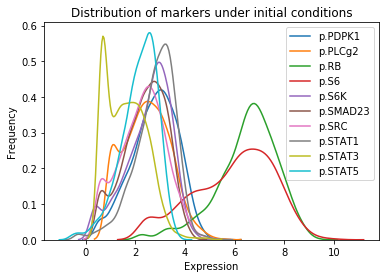

In [0]:
for col in pprot.columns[-10:]:
  if col in ['treatment','cell_line','cellID','fileID','time']:
    pass
  else:
    sns.distplot(pprot.loc[(pprot.treatment=='full'), col], norm_hist=True, hist=False, label=col)
  
plt.xlabel("Expression")
plt.ylabel("Frequency")
plt.title('Distribution of markers under initial conditions')
    #   sns.distplot(pprot['p.S6'], norm_hist=True, hist=False, label='2')
  # plt.legend(labels=['1','2'])
  # plt.show()

In [0]:
pprot.sample(10000).to_csv('/content/drive/My Drive/complete_cell_lines/184a1-sample.csv')

using tsne


<Figure size 432x288 with 0 Axes>

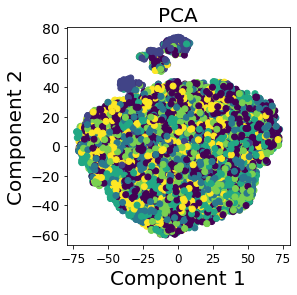

In [0]:

pca_plot('/content/drive/My Drive/complete_cell_lines/184a1-sample.csv', catcol='treatment', dim_method='tsne')

We can see that several of these markers point to multiple subpopulations within the cell population

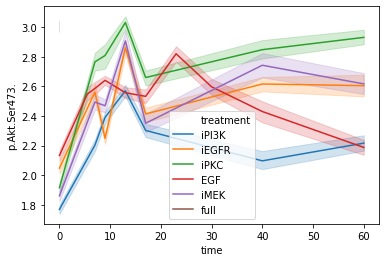

In [0]:
sns.lineplot(x='time',y='p.Akt.Ser473.',hue='treatment', data=pprot)

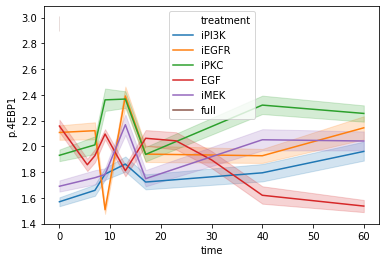

In [0]:
sns.lineplot(x='time',y='p.4EBP1',hue='treatment', data=pprot)

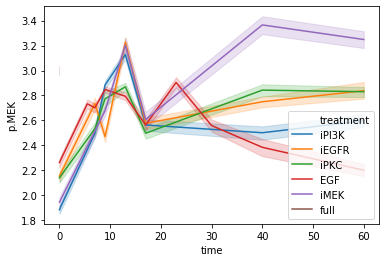

In [0]:
sns.lineplot(x='time',y='p.MEK',hue='treatment', data=pprot)

Below we have plotted IdU. We see that it is expressed at a higher level and much more stable, which may not be surprising given its role in proliferation and the short biological timeline.

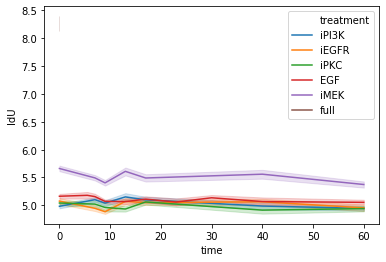

In [0]:
sns.lineplot(x='time',y='IdU',hue='treatment', data=pprot)

Effects from molecules are most discriminating at 60 min for several phosphoproteins. For exploration and visualization we will focus on this timepoint

In [0]:
pprot.treatment.unique()

array(['iPI3K', 'iEGFR', 'iPKC', 'EGF', 'iMEK', 'full'], dtype=object)

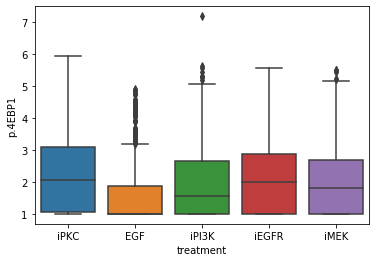

In [0]:
sns.boxplot(x="treatment", y="p.4EBP1", data=pprot[pprot.time==60])


In [0]:
pprot[pprot.time==60]

,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
371777,iPKC,184A1,60.0,8397,2685,1.951194,4.052408,2.38618,4.300457,4.82304,5.84801,3.765178,4.236685,3.822142,4.305247,3.874785,1.580122,4.393083,1.939917,2.90539,4.91502,5.213001,3.567431,2.124586,2.351484,3.44051,3.603284,5.30120,3.339646,3.711216,2.701489,4.32850,3.569554,3.216810,5.71977,7.07456,3.193296,3.342113,0.554053,3.82004,3.031018,2.11874
110930,EGF,184A1,60.0,3800,2701,1.660217,2.401222,1.20489,3.274183,4.96256,1.59085,1.445487,1.311366,1.089222,3.207228,2.880164,0.342840,2.317255,1.985719,1.52483,5.38934,4.871436,0.688867,1.882977,1.279194,1.70114,1.387530,3.81757,1.689195,2.217439,0.798554,1.62814,3.012352,2.877036,5.85994,4.27780,1.482228,2.137856,2.094397,1.47528,2.564319,1.67679
370682,iPKC,184A1,60.0,7302,2685,1.928004,3.070356,1.20489,2.822593,4.25020,1.59085,0.993163,2.248261,3.593092,3.323108,2.766869,0.342841,3.023868,1.697343,1.10118,3.91767,4.911051,2.847848,1.789620,1.032606,2.30577,2.844069,4.13226,1.817788,1.659141,2.549508,3.28641,2.428087,2.590219,5.31484,3.90900,1.453951,2.639613,1.066111,2.76930,1.913672,2.43995
363996,iPKC,184A1,60.0,616,2685,1.145236,2.468998,2.28196,4.410045,5.15180,1.59085,0.993163,2.339492,1.534811,4.141356,3.017091,0.734669,4.109388,0.462350,1.10118,6.18556,4.825500,3.049729,1.887907,2.781068,3.65882,3.261445,4.47488,2.870699,2.844193,0.803634,4.35982,2.848246,2.099531,5.12523,5.66114,3.073311,2.036211,0.761494,3.28503,1.817905,2.55596
310776,iPI3K,184A1,60.0,4457,2682,0.247702,2.139191,2.28984,3.428084,4.25020,1.59085,0.993163,2.162056,1.027096,3.137851,1.845578,0.342839,2.888279,2.729220,1.10118,3.24557,3.690090,0.688867,1.188996,1.227326,2.94600,1.483721,3.61627,2.323607,0.733225,2.118277,2.51864,2.387087,1.166837,2.89886,5.19251,1.615123,1.786778,1.744510,3.06043,2.443506,2.41048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312266,iPI3K,184A1,60.0,5947,2682,1.940592,2.727137,2.39638,3.378528,4.25020,1.59085,0.993163,2.177232,3.085776,3.203457,2.314000,0.342839,2.616803,2.269532,1.10118,4.86604,4.869270,1.439202,0.364099,2.480158,1.72548,1.315074,2.83655,2.366719,1.416234,2.009239,1.16414,2.290678,3.233494,6.08659,5.42415,0.331558,2.462383,1.017203,1.73022,2.869915,1.61040
238826,iMEK,184A1,60.0,256,2686,2.252369,3.549382,2.00133,4.559407,7.14265,1.59639,4.725110,4.508991,3.824258,4.277968,3.877551,0.679435,2.438421,1.952741,4.80087,4.52521,5.591687,2.038625,1.600669,3.034235,4.45750,4.114348,5.43132,3.120387,3.042741,0.919196,3.74237,3.725652,4.012512,4.69954,7.68090,2.723870,3.531439,2.750646,3.27056,4.637351,2.74780
107549,EGF,184A1,60.0,419,2701,1.412415,0.898342,1.74481,2.559622,5.55939,1.59085,2.329126,3.357774,1.282629,3.355412,1.951011,0.342839,1.565430,1.836230,2.63135,3.16213,2.810527,1.607483,0.364102,1.815055,3.00744,2.475979,3.45872,2.102132,3.057829,0.924950,2.02756,2.797715,1.895854,2.20794,5.55625,2.241798,0.551474,1.575795,2.78393,2.321914,1.49401
108467,EGF,184A1,60.0,1337,2701,1.494832,2.990170,1.33116,2.901617,4.25020,1.89497,1.338045,1.524289,2.408753,3.454559,1.974181,1.557437,2.311076,1.536953,1.58474,3.78306,4.546799,1.475797,1.488200,1.537337,2.05711,1.254860,3.84404,1.960621,0.548258,0.798554,2.88261,2.567135,2.082387,5.52968,4.60756,1.638107,2.882966,1.087894,2.09220,2.502004,2.80262


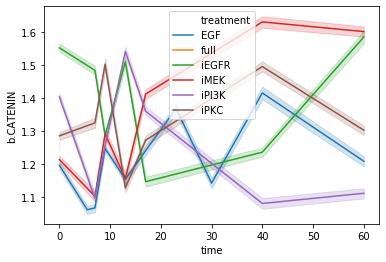

In [0]:
sns.lineplot(x='time',y='b.CATENIN',hue='treatment', data=pprot)

What is the relationship between the proteins?

In [0]:
prot_columns2=['treatment','p.4EBP1','p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB']
prot_columns=['b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1',
       'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK',
       'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2',
       'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53',
       'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6', 'p.S6K', 'p.SMAD23',
       'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5']

In [0]:
pprot1= pprot.sample(1000)

In [0]:
sns.pairplot(pprot.loc[(pprot.time==60) & (pprot.treatment=='full'),prot_columns])#, hue='cell_line')

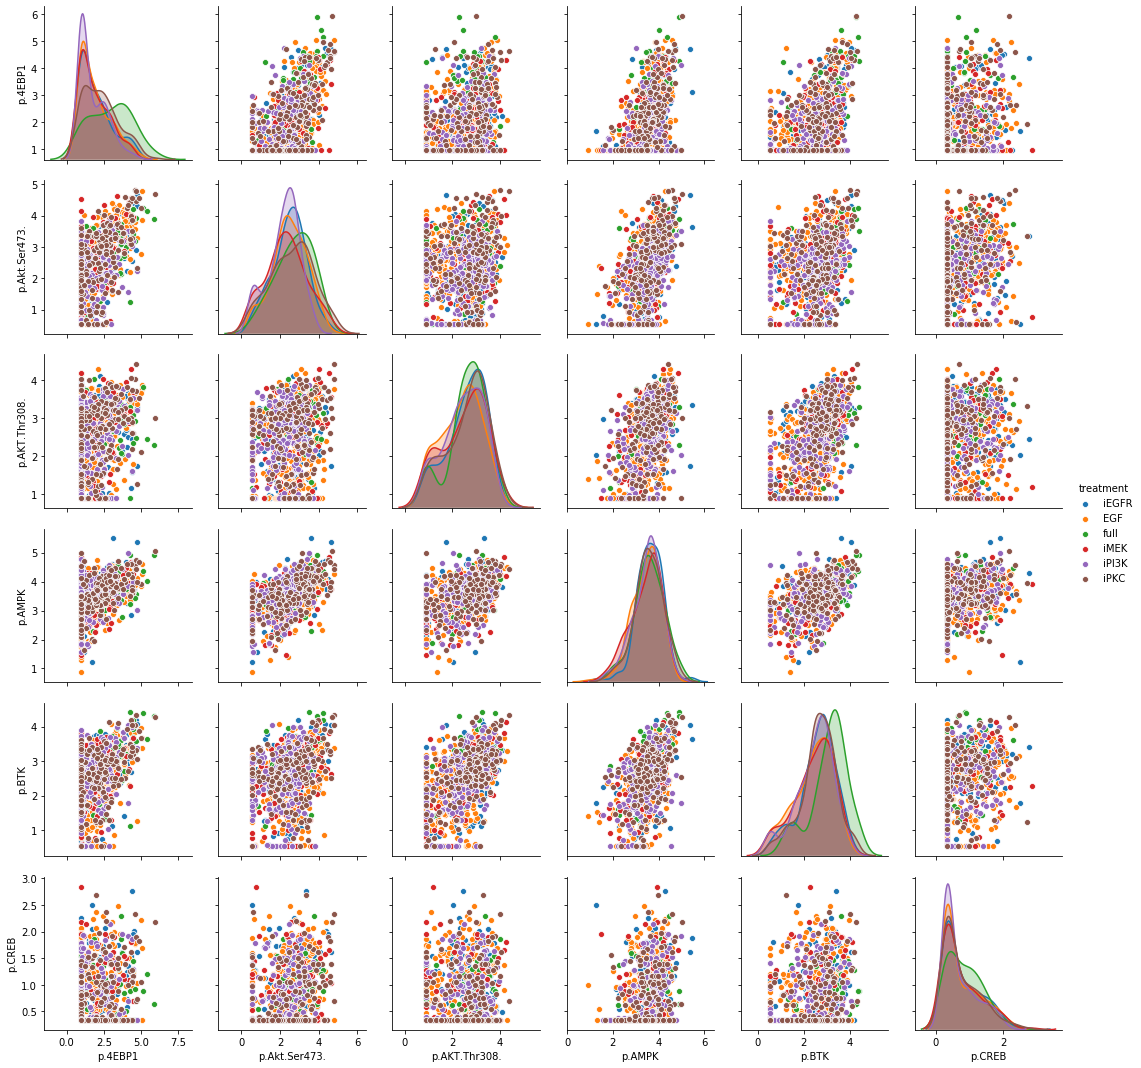

In [70]:
sns.pairplot(pprot1[prot_columns2], hue= 'treatment')

Do multiple cell lines show similar responses to drug treatment? We'll focus on the 60min timepoint and 1 drug (iMEK)

In [0]:
dir="/content/drive/My Drive/complete_cell_lines"
file_list=[]
for file in os.listdir(dir):
    if file.endswith(".csv"):
        file_list.append(os.path.join(dir, file))

In [0]:
def filter_lines(in_filename, out_filename):
  """Read records from in_filename and write records to out_filename if
  the string up to the first comma between positions 11 and 16 of
  line is found in the set keys.    """
  with open(in_filename) as in_f, open(out_filename,'a') as out_f:
#     print(in_filename)
    for line in in_f:
      #imek at time 60 ; or full (initial at time zero)
      if all(x in line  for x in ['iPI3K','60.']) or ('full' in line):
        out_f.write(line)
  return(None)


In [0]:
out_filename='/content/drive/My Drive/iMEK_all_lines.csv'
#add header to the csv file
pd.read_csv(file_list[0], nrows=0).to_csv(out_filename, index=False)
#add data from each cell line
for csvfile in file_list[3:7]:
  # print(csvfile)
  filter_lines(csvfile, out_filename)

In [0]:
imek=pd.read_csv(out_filename)
imek.sample(500).to_csv('/content/drive/My Drive/iMEK_sample.csv')

using tsne


<Figure size 432x288 with 0 Axes>

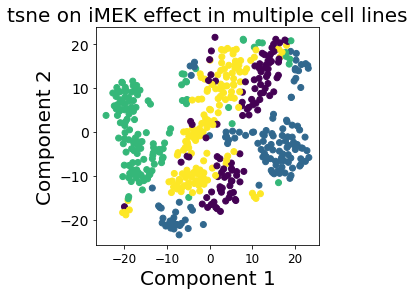

In [51]:
pca_plot('/content/drive/My Drive/iMEK_sample.csv', dim_method='tsne', catcol='cell_line', title='tsne on iMEK effect in multiple cell lines')


using tsne


<Figure size 432x288 with 0 Axes>

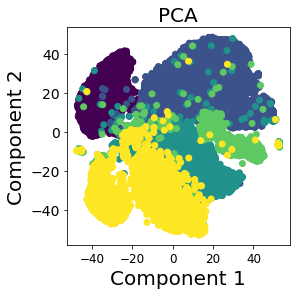

In [0]:
pca_plot(out_filename, dim_method='tsne', catcol='cell_line')

There is strong separation based on cell line.